Milestone 1:
We created a folder structure for a dataset with train and validation splits, ensuring a balanced representation of both classes in each split.
It is split 80/20 between training and validation sets.
Images and labels directories are split into train and val subdirectories.
The image count for each class is 500 samples.

In [7]:
import torch
from keras import activations
from keras.src.layers import ReLU
from tensorflow import convert_to_tensor, expand_dims, float32
from tensorflow.keras import layers, Sequential, regularizers
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image
from tensorflow.python.keras.callbacks import EarlyStopping
from ultralytics import YOLO

In [8]:
def load_dataset_from_annotation(annotation_file, images_base_path, img_size=(128, 128)):
    images = []
    labels = []

    with open(annotation_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                img_path = parts[0].strip()

                full_path = os.path.join(images_base_path, img_path)

                label = 1 if "homer_simpson" in line else 0

                try:
                    img = Image.open(full_path).convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0  # Normalize

                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {full_path}: {e}")
                    continue

    return np.array(images), np.array(labels)

X_train, y_train = load_dataset_from_annotation(
    "dataset/labels/train_annotations.txt",
    "dataset",
    img_size=(128, 128)
)

X_val, y_val = load_dataset_from_annotation(
    "dataset/labels/val_annotations.txt",
    "dataset",
    img_size=(128, 128)
)

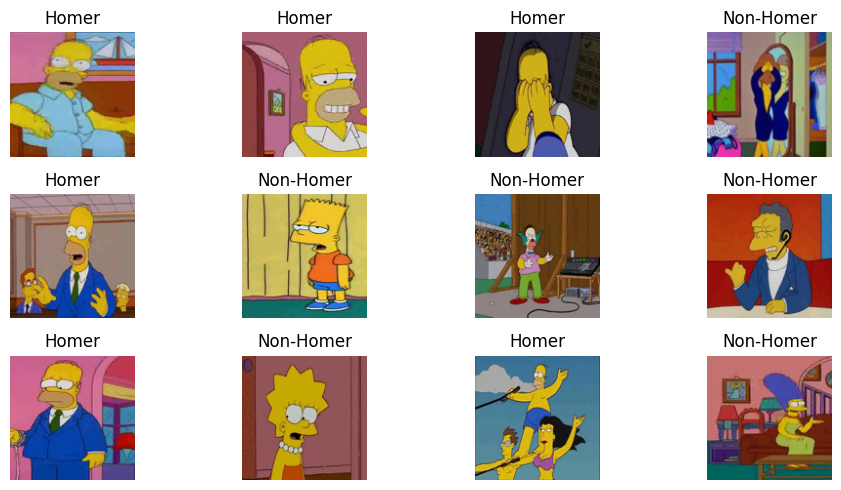

In [4]:
# visualize images
plt.figure(figsize=(10, 5))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_train[i])
    plt.title("Homer" if y_train[i] == 1 else "Non-Homer")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# baseline model

epochs = 20
batch_size = 32

baseline_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)
print("\nTraining metrics:")
train_results = baseline_model.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]:.4f}")

print("\nValidation metrics:")
base_val_results = baseline_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {base_val_results[0]:.4f}, Accuracy: {base_val_results[1]:.4f}")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - Precision: 0.5185 - Recall: 0.4900 - accuracy: 0.5175 - loss: 0.7002 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - Precision: 0.5385 - Recall: 0.6125 - accuracy: 0.5437 - loss: 0.6946 - val_Precision: 0.7500 - val_Recall: 0.1200 - val_accuracy: 0.5400 - val_loss: 0.6710
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - Precision: 0.5952 - Recall: 0.6250 - accuracy: 0.6000 - loss: 0.6592 - val_Precision: 0.5385 - val_Recall: 0.0700 - val_accuracy: 0.5050 - val_loss: 0.7174
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - Precision: 0.6017 - Recall: 0.7025 - accuracy: 0.6187 - loss: 0.6575 - val_Precision: 0.7321 - val_Recall: 0.4100 - val_accuracy: 0.6300 - val_loss: 0.6431
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - Precision: 0.6819 - Recall: 0.6700 - accuracy: 0.6787 - loss: 0.5901 - val_Precision: 0.6880 - val_Recall:

We got massiver overfitting!!. The validation is decent anyway, but we have to get rid of the overfitting.
Let's apply some regularization techniques such as L2 regularization to the dense layers and Dropout to reduce overfitting. Also reduce some neurons.

In [17]:
regularized_model = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', padding='same', # reduced conv filters, should memorize less training data
                 input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu', #also decreased the neurons
                 kernel_regularizer=regularizers.l2(0.01)), # penalizing larger weights
    layers.Dropout(0.5), # regularize the dense layers

    layers.Dense(64, activation='relu', # was 128
                 kernel_regularizer=regularizers.l2(0.01)), # penalize larger weights
    layers.Dropout(0.3), # regularize the dense layers

    layers.Dense(1, activation='sigmoid')
])

regularized_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

print("\nTraining metrics:")
train_results = regularized_model.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]:.4f}")

print("\nValidation metrics:")
reg1_val_results = regularized_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {reg1_val_results[0]:.4f}, Accuracy: {reg1_val_results[1]:.4f}")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - Precision: 0.5234 - Recall: 0.6150 - accuracy: 0.5275 - loss: 2.4026 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.4577
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.5031 - Recall: 0.8100 - accuracy: 0.5050 - loss: 1.2545 - val_Precision: 0.5165 - val_Recall: 0.9400 - val_accuracy: 0.5300 - val_loss: 1.0999
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.5294 - Recall: 0.7425 - accuracy: 0.5412 - loss: 1.0136 - val_Precision: 0.6304 - val_Recall: 0.8700 - val_accuracy: 0.6800 - val_loss: 0.9102
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.6798 - Recall: 0.6475 - accuracy: 0.6712 - loss: 0.8569 - val_Precision: 0.5697 - val_Recall: 0.9400 - val_accuracy: 0.6150 - val_loss: 0.8290
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.7081 - Recall: 0.6975 - accuracy: 0.7050 - loss: 0.7835 - val_Precision: 0.7955 - val_Recall: 0.70

We've got the overfitting down! Let's also try to implement EarlyStopping to see how it changes.

In [18]:
history = regularized_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    batch_size=batch_size
)

print("\nTraining metrics:")
train_results = regularized_model.evaluate(X_train, y_train, verbose=0)
print(f"Loss: {train_results[0]:.4f}, Accuracy: {train_results[1]:.4f}")

print("\nValidation metrics:")
reg2_val_results = regularized_model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {reg2_val_results[0]:.4f}, Accuracy: {reg2_val_results[1]:.4f}")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - Precision: 0.8832 - Recall: 0.8700 - accuracy: 0.8775 - loss: 0.3666 - val_Precision: 0.8384 - val_Recall: 0.8300 - val_accuracy: 0.8350 - val_loss: 0.4724
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - Precision: 0.9261 - Recall: 0.8775 - accuracy: 0.9038 - loss: 0.3427 - val_Precision: 0.8200 - val_Recall: 0.8200 - val_accuracy: 0.8200 - val_loss: 0.4887
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - Precision: 0.9077 - Recall: 0.8850 - accuracy: 0.8975 - loss: 0.3512 - val_Precision: 0.8605 - val_Recall: 0.7400 - val_accuracy: 0.8100 - val_loss: 0.4957
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - Precision: 0.9260 - Recall: 0.9075 - accuracy: 0.9175 - loss: 0.3430 - val_Precision: 0.8571 - val_Recall: 0.8400 - val_accuracy: 0.8500 - val_loss: 0.5097
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - Precision: 0.9328 - Recall: 0.9025 - accuracy: 0.9187 - loss: 0.3283 - val_Precision: 0.8750 - val_Recall: 0.77

Not a big change but this definitely saves us some time in running. There is room for improvement, but for this case, we will leave it at here. For example, we could've tried to use data augmentation to feed it more diverse data.

In [19]:
regularized_model.save('homer_classifier_model.h5')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


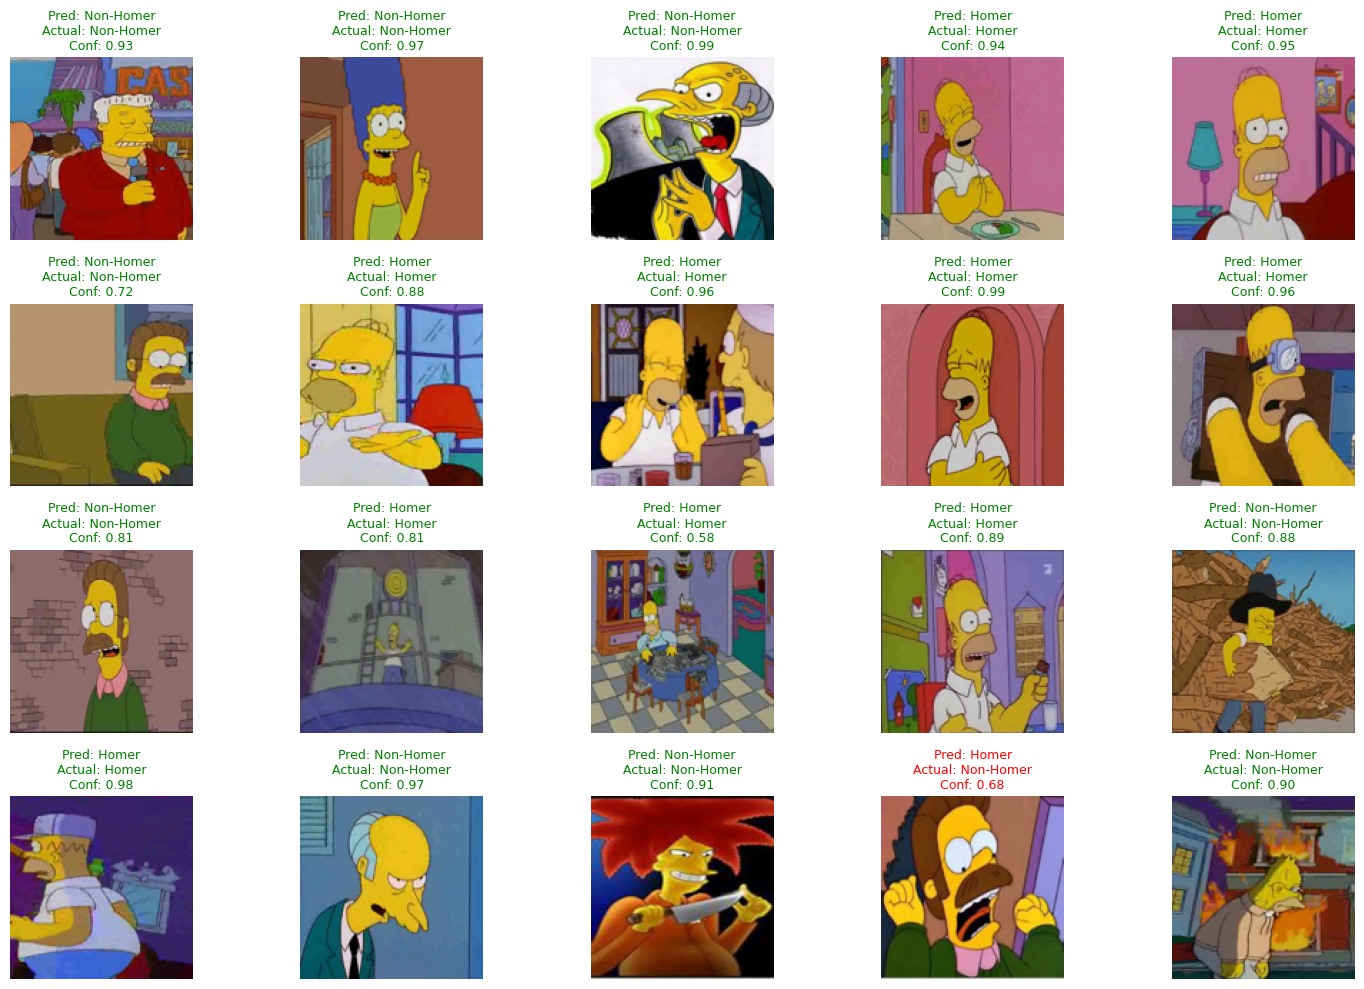


Validation Set Performance:
Correct predictions: 167/200
Accuracy: 83.50%

Confusion Matrix:
True Positives (Homer predicted as Homer): 83
True Negatives (Non-Homer predicted as Non-Homer): 84
False Positives (Non-Homer predicted as Homer): 16
False Negatives (Homer predicted as Non-Homer): 17


In [20]:
predictions = regularized_model.predict(X_val)
predicted_labels = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(15, 10))
num_images = 20

for i in range(num_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_val[i])

    pred = predicted_labels[i]
    actual = y_val[i]
    confidence = predictions[i][0] if pred == 1 else 1 - predictions[i][0]

    color = 'green' if pred == actual else 'red'
    pred_label = "Homer" if pred == 1 else "Non-Homer"
    actual_label = "Homer" if actual == 1 else "Non-Homer"

    plt.title(f"Pred: {pred_label}\nActual: {actual_label}\nConf: {confidence:.2f}",
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

correct = np.sum(predicted_labels == y_val)
total = len(y_val)
accuracy = correct / total

print(f"\nValidation Set Performance:")
print(f"Correct predictions: {correct}/{total}")
print(f"Accuracy: {accuracy:.2%}")
print(f"\nConfusion Matrix:")
print(f"True Positives (Homer predicted as Homer): {np.sum((predicted_labels == 1) & (y_val == 1))}")
print(f"True Negatives (Non-Homer predicted as Non-Homer): {np.sum((predicted_labels == 0) & (y_val == 0))}")
print(f"False Positives (Non-Homer predicted as Homer): {np.sum((predicted_labels == 1) & (y_val == 0))}")
print(f"False Negatives (Homer predicted as Non-Homer): {np.sum((predicted_labels == 0) & (y_val == 1))}")

Let's now convert the annotations to YOLO format and create the YAML file for object detection training. We have to note that the current annotations use box corners, not center-normalized bounding boxes as YOLO needs.

In [27]:
def create_yolo_labels(annotation_file, img_dir, label_dir):
    os.makedirs(label_dir, exist_ok=True)

    with open(annotation_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if ',' in line:
            parts = line.strip().split(',')

            img_path = parts[0]
            img_name = os.path.basename(img_path)

            x1, y1, x2, y2 = map(float, parts[1:5])
            class_label = parts[5]

            actual_img = f"{img_dir}/{img_name}"
            if not os.path.exists(actual_img):
                continue

            try:
                with Image.open(actual_img) as img:
                    W, H = img.size
            except:
                continue

            left = min(x1, x2)
            right = max(x1, x2)
            top = min(y1, y2)
            bottom = max(y1, y2)

            width = right - left
            height = bottom - top

            x_center = (left + width/2) / W
            y_center = (top + height/2) / H
            width_norm = width / W
            height_norm = height / H

            class_id = 0 if class_label == 'homer_simpson' else 1

            txt_name = img_name.rsplit('.', 1)[0] + '.txt'
            txt_path = f"{label_dir}/{txt_name}"

            with open(txt_path, 'w') as f:
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")

create_yolo_labels(
    "dataset/labels/train_annotations.txt",
    "dataset/images/train",
    "dataset/labels/train"
)

create_yolo_labels(
    "dataset/labels/val_annotations.txt",
    "dataset/images/val",
    "dataset/labels/val"
)

yaml_content = """path: ./dataset
train: images/train
val: images/val
nc: 2
names: ['homer_simpson', 'not_homer']
"""

with open("simpsons.yaml", "w") as f:
    f.write(yaml_content)

Now let's double check that the YOLO labels are correct by visualizing some images with their bounding boxes.

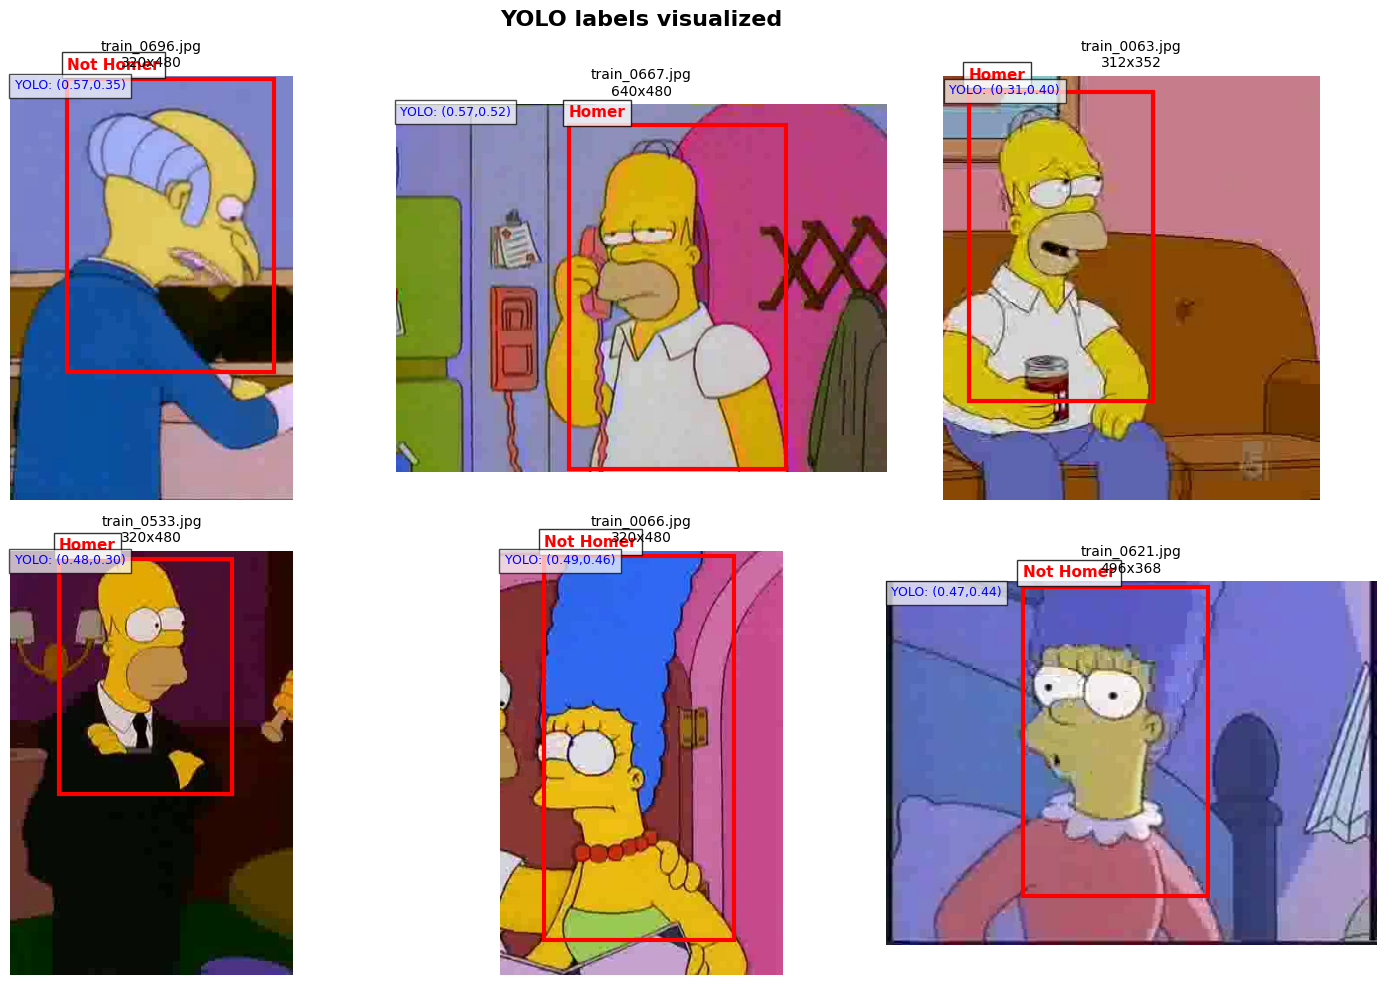

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import numpy as np

np.random.seed(42)
all_images = []
for root, dirs, files in os.walk("dataset/images/train"):
    for f in files:
        if f.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_images.append(f)

selected = np.random.choice(all_images, 6, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_name in enumerate(selected):
    ax = axes[idx]
    img_path = f"dataset/images/train/{img_name}"

    img = Image.open(img_path).convert('RGB')
    img_array = np.array(img)
    H, W = img_array.shape[:2]

    # FIND YOLO ANNOTATION (.txt file)
    txt_name = img_name.rsplit('.', 1)[0] + '.txt'
    txt_path = f"dataset/labels/train/{txt_name}"

    ax.imshow(img_array)

    if os.path.exists(txt_path):
        # Read YOLO format
        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            if line:
                parts = line.split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width_norm, height_norm = map(float, parts)

                    # Convert YOLO to pixel coordinates
                    x_center_px = x_center * W
                    y_center_px = y_center * H
                    width_px = width_norm * W
                    height_px = height_norm * H

                    left = x_center_px - width_px/2
                    top = y_center_px - height_px/2

                    # Draw box
                    rect = patches.Rectangle(
                        (left, top), width_px, height_px,
                        linewidth=3, edgecolor='red', facecolor='none'
                    )
                    ax.add_patch(rect)

                    class_name = "Homer" if class_id == 0 else "Not Homer"
                    ax.text(left, top-10, class_name,
                            color='red', fontsize=11, fontweight='bold',
                            bbox=dict(facecolor='white', alpha=0.8))

                    # Show YOLO coordinates
                    ax.text(5, 15, f"YOLO: ({x_center:.2f},{y_center:.2f})",
                            color='blue', fontsize=9,
                            bbox=dict(facecolor='white', alpha=0.7))


    ax.set_title(f"{img_name}\n{W}x{H}", fontsize=10)
    ax.axis('off')

plt.suptitle("YOLO labels visualized", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

 Now as we can see the yolo labels are properly positioned, we can start training the object detection.

In [2]:
model = YOLO('yolov5s.pt')

print("using gpu:", torch.cuda.is_available())

results = model.train(
    data='simpsons.yaml',
    epochs=20,
    imgsz=416,
    batch=4,
    name='simpsons_yolo_v1',
    patience=10,
    device='cuda'
)

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

using gpu: True
Ultralytics 8.3.234  Python-3.13.5 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=simpsons.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, 

In [4]:
model = YOLO('runs/detect/simpsons_yolo_v115/weights/best.pt')

results = model.predict(
    source='dataset/images/val',
    imgsz=416,
    conf=0.25,
    device='cuda'
)


image 1/200 E:\Code\ML\homiedar\dataset\images\val\val_0000.jpg: 416x288 3 not_homers, 77.5ms
image 2/200 E:\Code\ML\homiedar\dataset\images\val\val_0001.jpg: 320x416 1 not_homer, 73.2ms
image 3/200 E:\Code\ML\homiedar\dataset\images\val\val_0002.jpg: 416x416 1 homer_simpson, 11.4ms
image 4/200 E:\Code\ML\homiedar\dataset\images\val\val_0003.jpg: 320x416 1 homer_simpson, 12.2ms
image 5/200 E:\Code\ML\homiedar\dataset\images\val\val_0004.jpg: 320x416 1 homer_simpson, 12.5ms
image 6/200 E:\Code\ML\homiedar\dataset\images\val\val_0005.jpg: 416x384 2 not_homers, 74.5ms
image 7/200 E:\Code\ML\homiedar\dataset\images\val\val_0006.jpg: 416x288 2 homer_simpsons, 11.2ms
image 8/200 E:\Code\ML\homiedar\dataset\images\val\val_0007.jpg: 320x416 1 homer_simpson, 11.6ms
image 9/200 E:\Code\ML\homiedar\dataset\images\val\val_0008.jpg: 320x416 1 homer_simpson, 11.6ms
image 10/200 E:\Code\ML\homiedar\dataset\images\val\val_0009.jpg: 320x416 1 homer_simpson, 14.0ms
image 11/200 E:\Code\ML\homiedar\data

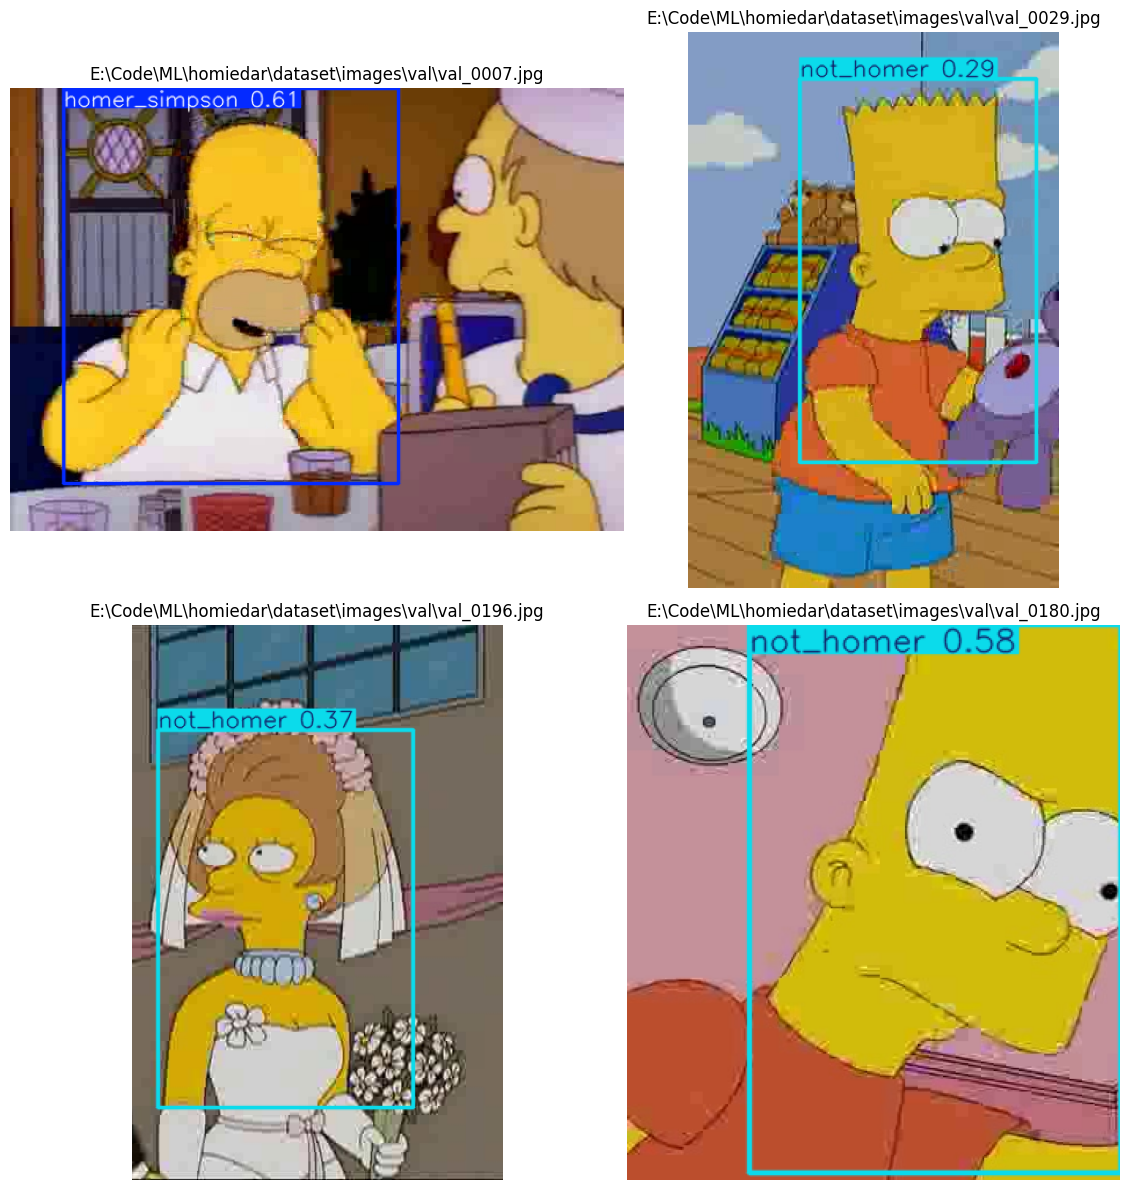

In [11]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

random_results = random.sample(results, 4)

for ax, result in zip(axes, random_results):
    img_with_boxes = result.plot()  # BGR image
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(result.path.split('/')[-1], fontsize=12)

plt.tight_layout()
plt.show()

In [43]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

print("Loading style transfer model...")
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

style_image_path = "image2.jpg"
style_image = cv2.imread(style_image_path)
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
style_image = tf.image.resize(style_image, (256, 256))
style_image = style_image / 255.0
style_image = tf.expand_dims(style_image, 0)

def gan_style_transfer(crop_img):
    # Convert BGR to RGB
    crop_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)

    # Prepare content image
    content_img = tf.image.resize(crop_rgb, (256, 256))
    content_img = content_img / 255.0
    content_img = tf.expand_dims(content_img, 0)

    # Apply style transfer
    stylized = hub_model(content_img, style_image)[0]

    # Resize back to original crop size
    h, w = crop_img.shape[:2]
    stylized = tf.image.resize(stylized[0], (h, w))
    stylized = (stylized.numpy() * 255).astype(np.uint8)

    # Convert back to BGR
    stylized_bgr = cv2.cvtColor(stylized, cv2.COLOR_RGB2BGR)

    return stylized_bgr

Loading style transfer model...


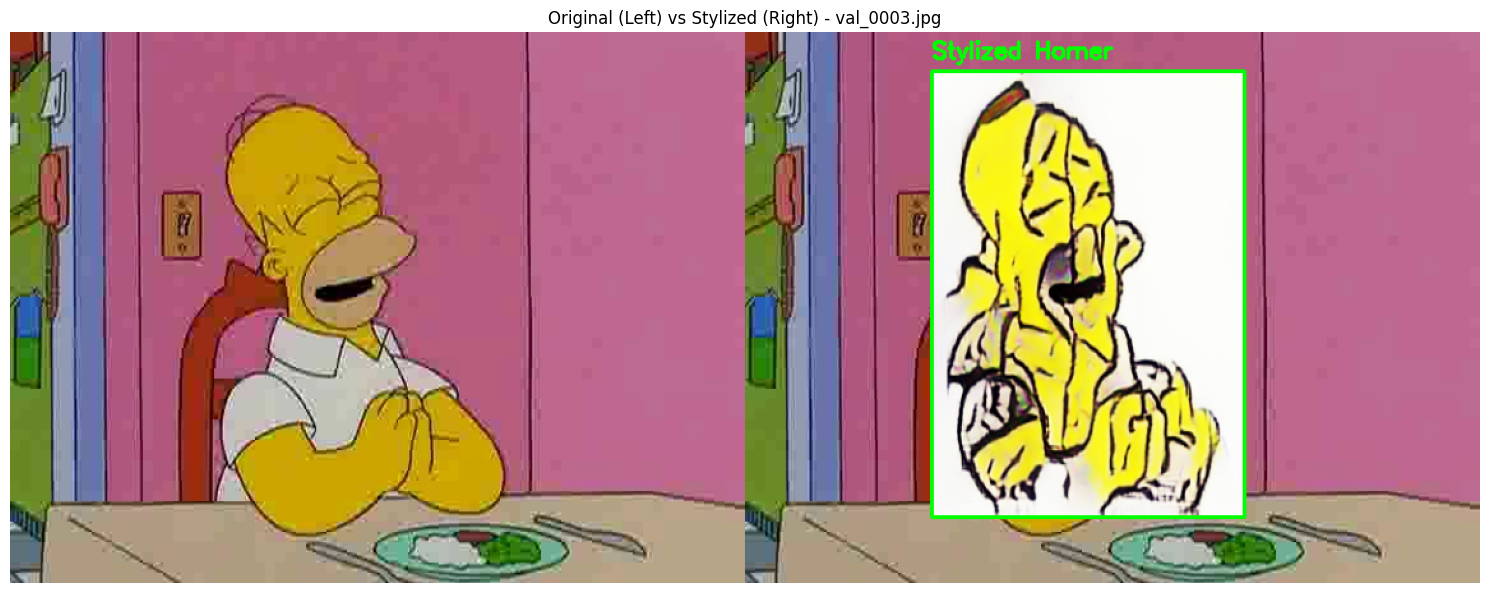

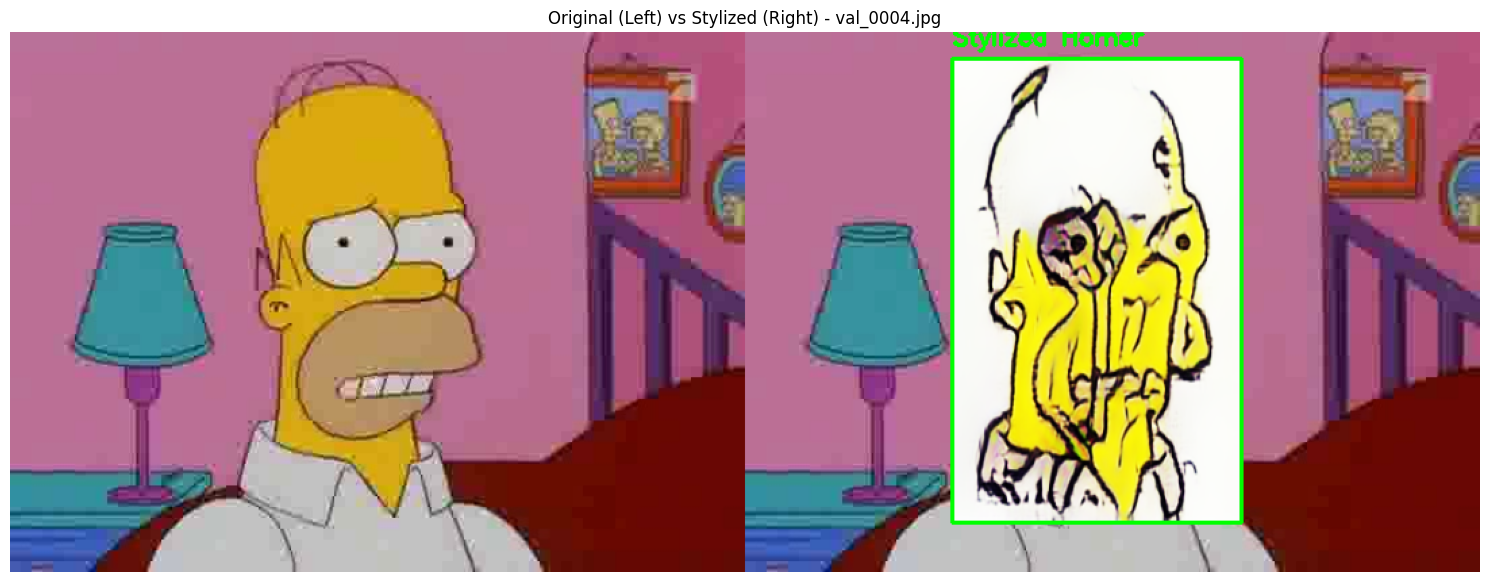

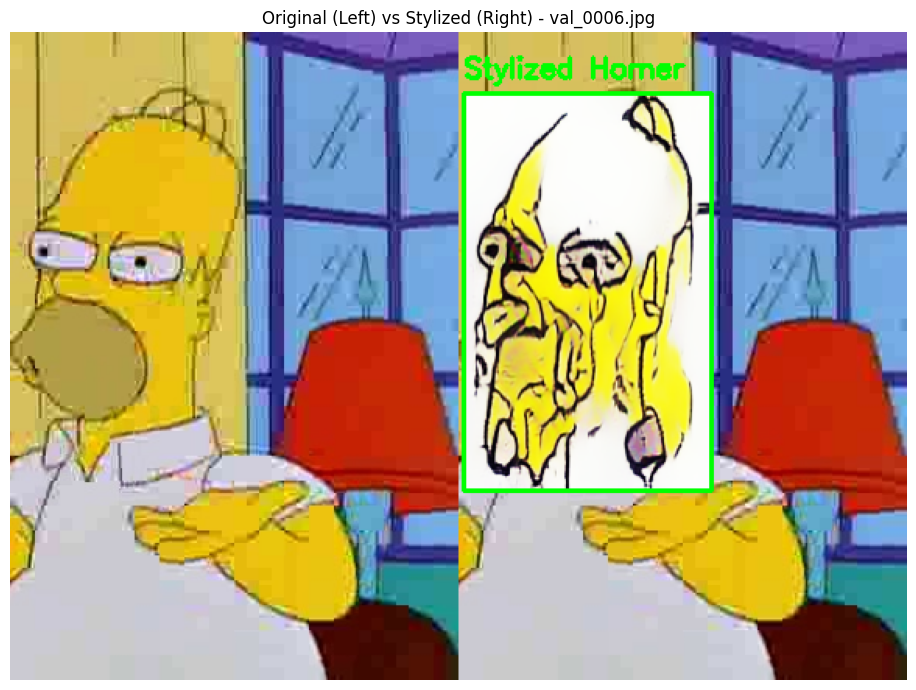

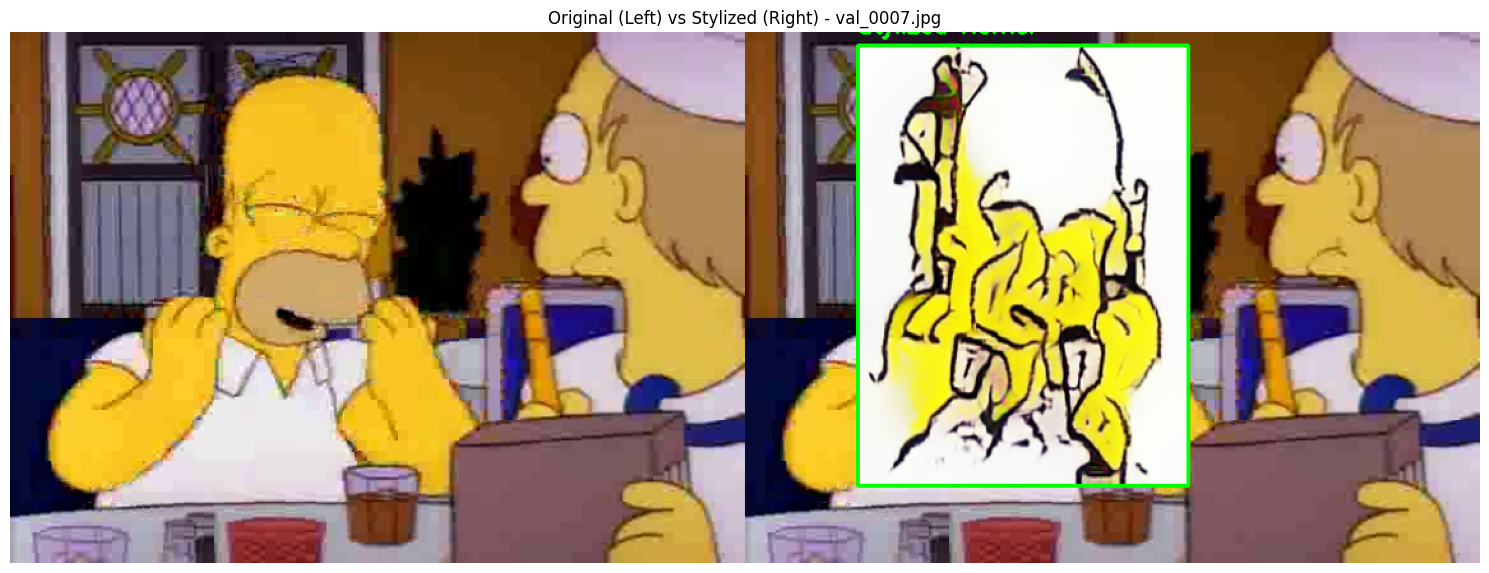

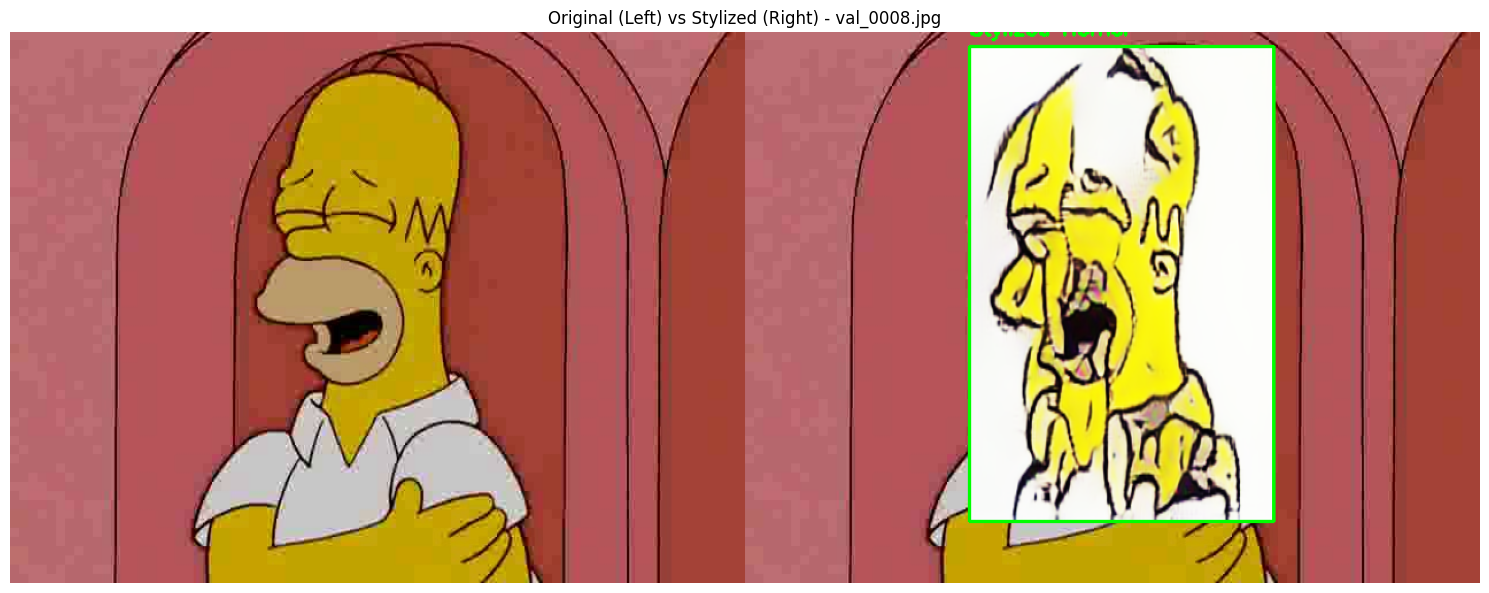

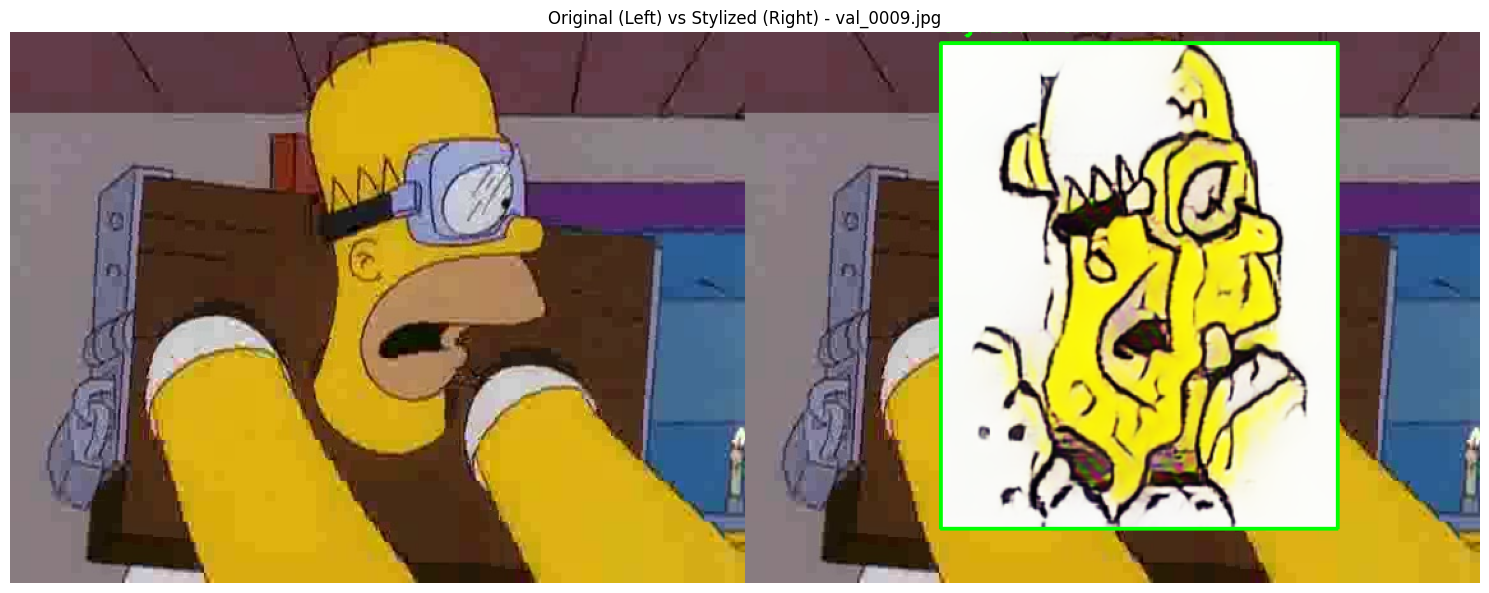

In [44]:
import os
import cv2
import matplotlib.pyplot as plt

test_images = [f for f in os.listdir("dataset/images/val") if f.endswith(('.jpg', '.png', '.jpeg'))][:10]
composite_count = 0

for fname in test_images:
    input_path = os.path.join("dataset/images/val", fname)
    orig_img = cv2.imread(input_path)
    if orig_img is None:
        continue

    # YOLO inference
    results = model.predict(input_path, imgsz=640, conf=0.25, verbose=False)
    composite_img = orig_img.copy()

    detected_homer = False

    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls[0])
            if cls_id != 0:
                continue

            detected_homer = True
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Crop detection
            crop = orig_img[y1:y2, x1:x2].copy()
            if crop.size == 0:
                continue
            # GAN-style transfer
            stylized_crop = gan_style_transfer(crop)
            # Paste stylized crop back
            composite_img[y1:y2, x1:x2] = stylized_crop
            # Draw bounding box on composite
            cv2.rectangle(composite_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(composite_img, "Stylized Homer", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    if detected_homer:
        comparison = np.hstack([orig_img, composite_img])
        # Display first 2 examples
        comparison_rgb = cv2.cvtColor(comparison, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(15, 7))
        plt.imshow(comparison_rgb)
        plt.title(f"Original (Left) vs Stylized (Right) - {fname}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()